# Introduction
This notebook loads in analysis of B-cells isolated from PBMC's from a healthy donor and analyzed on the 10X Genomics platform. Data was downloaded from the 10X website (https://support.10xgenomics.com/single-cell-gene-expression/datasets/1.1.0/fresh_68k_pbmc_donor_a). Instructions on using the ``matrix.mtx`` files are included here: https://support.10xgenomics.com/single-cell-gene-expression/software/pipelines/latest/output/matrices. We will follow this tutorial

In [1]:
# import necessary packages
import csv
import os
import scipy.io
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import numpy as np
import scipy.sparse as sps
import multiprocessing as mp

In [2]:
# set paths
genome = "hg19"
celltype = "bcells"
matfolder = "filtered_matrices_mex"
clusterfolder = "analysis_csv"
scrnaseq_dir = "../scrnaseq_10x/"

bcell_matrix_dir = os.path.join(scrnaseq_dir,celltype,matfolder,genome)
bcell_analysis_dir = os.path.join(scrnaseq_dir,celltype,clusterfolder)

pca_dir = os.path.join(bcell_analysis_dir,"pca")
tsne_dir = os.path.join(bcell_analysis_dir,"tsne")
kmeans_dir = os.path.join(bcell_analysis_dir,"kmeans")

In [12]:
#set import functions

def import_matrixmtx_file(filename):
    inmat = scipy.io.mmread(source=filename)
    sparsepd = pd.SparseDataFrame(inmat)
    return(sparsepd)

#how can we generate a SparseDataFrame from a Sparse Matrix without creating a dense matrix in memory?

# def import_csv(filename,delimiter="\t"):
#     ids = [row[0] for row in csv.reader(open(filename), delimiter=delimiter)]
#     names = [row[1] for row in csv.reader(open(filename), delimiter=delimiter)]
#     return(ids,names)


In [13]:
#import the file. Use multiprocessing to make this run smoother
mp_pool = mp.Pool(5)

inmatrix = os.path.join(bcell_matrix_dir, "matrix.mtx")
genes_path = os.path.join(bcell_matrix_dir, "genes.tsv")
barcodes_path = os.path.join(bcell_matrix_dir, "barcodes.tsv")

infile = mp_pool.map(import_matrixmtx_file, [inmatrix])


Process ForkPoolWorker-15:
Process ForkPoolWorker-14:
Process ForkPoolWorker-13:
Process ForkPoolWorker-12:
Process ForkPoolWorker-11:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/vinayakvsv/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/vinayakvsv/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/vinayakvsv/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/vinayakvsv/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/vinayakvsv/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/vinayakvsv/anaconda3/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()

In [16]:
mat = infile[0]
print(mat.shape)
print(type(mat))

(32738, 10085)
<class 'pandas.core.sparse.frame.SparseDataFrame'>


In [17]:
# load the gene IDs and names
gene_ids = [row[0] for row in csv.reader(open(genes_path), delimiter="\t")]
gene_names = [row[1] for row in csv.reader(open(genes_path), delimiter="\t")]

In [18]:
# load the barcode IDs
barcodes = [row[0] for row in csv.reader(open(barcodes_path), delimiter="\t")]

In [19]:
genes_df = pd.DataFrame()
genes_df = genes_df.assign(genename=pd.Series(gene_names),geneid=pd.Series(gene_ids))

In [20]:
# for multi-core jobs
# https://stackoverflow.com/questions/33480675/multiprocessing-on-a-set-number-of-cores

We now load T-SNE metadata for this population. We will show what the populations look like and then isolate the cells responsible to generate co-expression blocks

In [21]:
#tsne_data = scipy.io.mmread(os.path.join(tsne_dir, "projection.csv")) 
tsne_data = os.path.join(tsne_dir, "projection.csv")
tsne_points = [row for row in csv.reader(open(tsne_data), delimiter=",")]
tsne_meta = pd.DataFrame(tsne_points[1:])
tsne_meta.columns = tsne_points[0]

In [22]:
#import clustering
cluster_10 = os.path.join(kmeans_dir,"10_clusters")
print(cluster_10)
#get the cluster designations
cluster_10_ids = pd.read_csv(os.path.join(cluster_10,"clusters.csv"))
#cluster_10_ids
#kmeans_10 = os.path.join(pca_dir,"10_clusters") 

../scrnaseq_10x/bcells/analysis_csv/kmeans/10_clusters


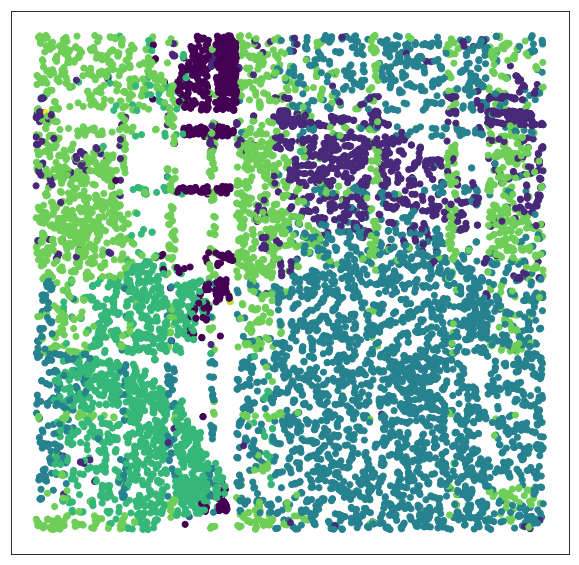

In [23]:
plt.figure(figsize=(10, 10))
plt.scatter(tsne_meta.iloc[:,1],tsne_meta.iloc[:,2],c = cluster_10_ids.iloc[:,1])
plt.xticks([])
plt.yticks([])
plt.show()

# Isolate groups of cells
Now, we want to identify putative groups of cells (from the 10-cluster scheme) and calculate co-expression matrices fo the genes using measurements from each cluster of cells (we will have as any matrices as we have cells). We will calculate these co-expression matrices for the whole set of ~30,000 genes and represent it as a plot. 

In [67]:
# cellgroups = [None for i in clusters]
# for i in clusters:
#     cells = cluster_10_ids[cluster_10_ids.Cluster == i] #get the cells in the cluster "i"
#     cells_ind = cells.index
#     mat_csr = mat.tocsr()
#     cellgroups[i-1] = scipy.sparse.coo_matrix(mat_csr[:,cells_ind.tolist()]) #cells_ind  

NameError: name 'mat' is not defined

In [24]:
# def get_cluster(clusterid,cellmat,cluster_ids):
#     cells = cluster_ids[cluster_ids.Cluster == clusterid]
#     cells_ind = cells.index
#     mat_csr = mat.tocsr()
#     return(scipy.sparse.coo_matrix(mat_csr[:,cells_ind.tolist()]))

def get_cluster(clusterid,celldf,cluster_ids):
    cells = cluster_ids[cluster_ids.Cluster == clusterid]
    cells_ind = cells.index
    mat_cells_ind = celldf.iloc[cells_ind.tolist(),:]
    return(mat_cells_ind)
#    mat_csr = mat.tocsr()
#    return(scipy.sparse.coo_matrix(mat_csr[:,cells_ind.tolist()]))

mp_pool = mp.Pool(4)
clusters = [(i,mat,cluster_10_ids) for i in set(cluster_10_ids.iloc[:,1])]
cellgroups = mp_pool.starmap(get_cluster, clusters)

Process ForkPoolWorker-17:
Process ForkPoolWorker-19:
Process ForkPoolWorker-16:
Process ForkPoolWorker-18:
Traceback (most recent call last):
  File "/Users/vinayakvsv/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/vinayakvsv/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/vinayakvsv/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/vinayakvsv/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/vinayakvsv/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/vinayakvsv/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs

In [107]:
def calculate_sparsemat_covariance(sparsemat):
    A = sparsemat
    n = A.shape[1] #gets the number of cells; shape[0[] would give the number of variables
    rowsum = A.sum(1)
    
    #compute covariance matrix
    centering = rowsum.dot(rowsum.T.conjugate()) / n
    C = (A.dot(A.T.conjugate()) - centering) / (n - 1)

#     # The correlation coefficients are given by
#     # C_{i,j} / sqrt(C_{i} * C_{j})
#     d = np.diag(C)
#     coeffs = C / np.sqrt(np.outer(d, d))

    return C#coeffs


In [57]:
def calculate_corr(pd_df):
    return pd_df.corr(method="pearson") #pearson is default

In [39]:
cluster_0 = cellgroups[0]

mp_pool = mp.Pool(4)

corrdfs = mp_pool.map(calculate_corr,cellgroups)

#print(cluster_0)
#print(cluster_0.shape)
#cluster_0.corr()
#cov_cluster_0 = calculate_sparsemat_correlation(cluster_0)
#cluster_0.sum(1).dot(cluster_0.sum(1).T.conjugate()).shape

In [60]:
#keey the clusters that have more than 'ncell' cells
ncell = 1
inds = [None for i in range(len(cellgroups))]
for i in range(len(cellgroups)):
    if cellgroups[i].shape[0] > ncell:
        inds[i] = i
inds = [i for i in inds if i is not None]
print(inds)
corrdfs_actual = [corrdfs[i] for i in inds]
for i in [j for j in cellgroups]:
    print(i.shape)

[0, 1, 4, 6, 7]
(664, 10085)
(1275, 10085)
(1, 10085)
(1, 10085)
(3882, 10085)
(1, 10085)
(1636, 10085)
(2623, 10085)
(1, 10085)
(1, 10085)


In [56]:
#corrdfs_actual[3]

,0,1,2,3,4,5,6,7,8,9,...,10075,10076,10077,10078,10079,10080,10081,10082,10083,10084
0,1.000000,0.867136,0.925756,0.542310,0.687578,0.918557,0.971849,0.957301,0.846169,0.962448,...,0.848907,0.853442,0.869237,0.961773,0.764795,0.953756,0.840982,0.879552,0.797049,0.900582
1,0.867136,1.000000,0.969725,0.865206,0.953612,0.982019,0.883812,0.942065,0.967916,0.878235,...,0.956476,0.981282,0.995975,0.895819,0.992675,0.936854,0.988886,0.977768,0.968139,0.961831
2,0.925756,0.969725,1.000000,0.796807,0.885168,0.986576,0.938520,0.987618,0.956842,0.954073,...,0.916432,0.971966,0.963677,0.921271,0.818392,0.930675,0.952080,0.959146,0.920485,0.959767
3,0.542310,0.865206,0.796807,1.000000,0.886223,-0.225018,0.636479,0.704896,0.854982,0.667612,...,0.862449,0.943876,0.881656,0.506218,0.188982,0.630827,0.903712,0.726794,0.911753,0.894643
4,0.687578,0.953612,0.885168,0.886223,1.000000,0.897993,0.696461,0.781822,0.889592,0.677016,...,0.840535,0.941676,0.951697,0.700220,0.964695,0.795096,0.918038,0.932578,0.949836,0.890513
5,0.918557,0.982019,0.986576,-0.225018,0.897993,1.000000,0.931337,0.966242,0.913175,0.846668,...,0.927953,0.943149,0.980195,0.961891,0.963106,0.986414,0.934531,0.989060,0.923860,0.938141
6,0.971849,0.883812,0.938520,0.636479,0.696461,0.931337,1.000000,0.984903,0.885725,0.988979,...,0.893620,0.894120,0.913576,0.921137,0.796764,0.921046,0.876676,0.882250,0.866114,0.939874
7,0.957301,0.942065,0.987618,0.704896,0.781822,0.966242,0.984903,1.000000,0.924062,0.971577,...,0.964362,0.942487,0.956652,0.930855,0.882200,0.951191,0.919164,0.922372,0.893116,0.969277
8,0.846169,0.967916,0.956842,0.854982,0.889592,0.913175,0.885725,0.924062,1.000000,0.864463,...,0.974174,0.979238,0.980422,0.761819,0.939081,0.851894,0.990777,0.901035,0.987844,0.984827
9,0.962448,0.878235,0.954073,0.667612,0.677016,0.846668,0.988979,0.971577,0.864463,1.000000,...,0.891626,0.895825,0.903688,0.910995,0.762587,0.906767,0.845717,0.879361,0.837997,0.916958


In [ ]:
def plot_coo_matrix(m):
#     if not isinstance(m, scipy.sparse.coo_matrix):
#         m = scipy.sparse.coo_matrix(m)
    fig = plt.figure()
    #ax = fig.add_subplot(111, axisbg='black')
    ax.plot(m.col, m.row, 's', ms=1)
    ax.set_xlim(0, m.shape[1])
    ax.set_ylim(0, m.shape[0])
    ax.set_aspect('equal')
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.invert_yaxis()
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    return ax


In [ ]:
#from https://stackoverflow.com/questions/19231268/correlation-coefficients-for-sparse-matrix-in-python
def sparse_corrcoef(A, B=None):

    if B is not None:
        A = sparse.vstack((A, B), format='csr')

    A = A.astype(np.float64)
    n = A.shape[1]
    print(n)

    # Compute the covariance matrix
    rowsum = A.sum(1)
    centering = rowsum.dot(rowsum.T.conjugate()) / n
    C = (A.dot(A.T.conjugate()) - centering) / (n - 1)

    # The correlation coefficients are given by
    # C_{i,j} / sqrt(C_{i} * C_{j})
    d = np.diag(C)
    coeffs = C / np.sqrt(np.outer(d, d))

    return coeffs

In [ ]:
for i in cellgroups:
    print(i.shape)
#cellgroups[4]
#mat_csr = mat.tocsr()
#mat_csr[2,cellgroups[0].tolist()]
#    mat_group = mat.tocsc[0:100] cells_ind

In [ ]:
test_corr = sparse_corrcoef(A=cellgroups[0])

In [ ]:
#import statsmodels

In [ ]:
test_corr_nona = np.nan_to_num(test_corr) #replace all NA with 0

In [ ]:
test_corr_sparse = scipy.sparse.coo_matrix(test_corr)
#print(type(test_corr_sparse))

#ax = sparse_corrcoef(test_corr)
#ax.figure

In [ ]:
print(np.amax(np.sum(a=test_corr_nona,axis=0))) #so this does work
test_corr_nona_sparse = scipy.sparse.coo_matrix(test_corr_nona) #store as a sparce matrix

In [ ]:
#import cooler
test_corr_nona_sparse.todense()

# Isolating co-expression domains

Rather than solving a "clustering" problem, we would like to identify contiguous blocks along the diagonal where "squares" exist. This is essentially a Hi-C problem (to call TADs), and we can involve "cooltools" to do so.

We could think of the problem "algorithmically" as such:

1. Given n points and n^2 relationships to each other, how can we identify m groupings such that the total signal within the 

The clustering analysis turned out differentially-expressed genes for each cluster, so we could calculate a co-expression matrix using just those genes (rather than those with no counts recorded). Nevertheless, now we can perform matrix operations on the coo_matrix to identify the "blocks" of co-expressed genes.

This is a job for "block modelling." https://stats.stackexchange.com/questions/138325/clustering-a-correlation-matrix 

In [ ]:
#how do we efficiently identify blocks? Bin the genome into 100 kb blocks and calculate correlations between genes within them?

#first, let's get a distribution of correlation values:
n, bins, patches = plt.hist(test_corr_nona[0:100][0:100])
plt.show()


# Compare co-expression domains and contact scores from HiC data

We will perform the following procedure
1. For the lower-left diagonal of the matrix, take each diagonal slice parallel to the hypotenuse
    * Each slice represents some scale of genomic distance between regions. We would like to compute the whether particular contact-coexpression trends stand out over long genomic distances
2. Obtain both the contact scores and the expression correlation of all genes in the genomic bins throughout the slice. 
3. We ultimately want to calculate some "threshold" at which genomic proximity and gene co-expression are potentially significant. 
* Weight the signal used to compute correlation by the number of genes present (assign an "uncertainty" to the reads mapping to the genes in the bin)